# 📈 Portfolio Optimization with Markowitz Model

This script builds aggressive and defensive portfolios using historical data from Yahoo Finance. 
It applies mean-variance optimization to maximize returns and minimize risk, then backtests over a 3-year period.

## 🧾 1. Import Libraries

In [67]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import cvxpy as cp
import time

## 💼 2. Define Tickers and Dates

In [68]:
# Diversified asset selection: Tech, Energy, Banking, Pharma, FMCG, etc.
aggressive_tickers = ["TSLA", "RELIANCE.NS", "INDA", "AAPL", "NVDA", "QQQ", "ARKK", "META"]
defensive_tickers = ["WMT", "GLD", "CIPLA.NS", "SBILIFE.NS", "TLT", "VNQ", "XLU", "MCD"]

# Training period (used for optimization)
start_date = "2019-04-01"
end_date = "2022-03-31"

# Testing period (used for backtesting)
start_date2 = "2022-04-01"
end_date2 = "2025-03-31"

## 💾 3. Data Download Function

In [69]:
def download_price_and_returns(tickers, start_date, end_date):
    """Download adjusted close prices and calculate daily returns."""
    all_closes = pd.DataFrame()
    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)['Close']
            all_closes[ticker] = data
        except Exception as e:
            print(f"Failed to download {ticker}: {e}")
    
    returns = all_closes.pct_change().dropna()
    return all_closes, returns

## 📊 4. Markowitz Optimization Functions

In [70]:
def def_markowitz_optimizer(mean_returns, cov_matrix, target_returns, weight_bounds=(0.0, 0.33), risk_free_rate=0.06):
    """Defensive portfolio optimizer - minimize risk for a target return."""
    n_assets = len(mean_returns)
    weights = cp.Variable(n_assets)
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    portfolio_return = mean_returns.values @ weights

    results = {'risks': [], 'weights': [], 'sharpe_ratios': []}

    for target in target_returns:
        constraints = [
            cp.sum(weights) == 1,
            weights >= weight_bounds[0],
            weights <= weight_bounds[1],
            portfolio_return >= target
        ]
        prob = cp.Problem(cp.Minimize(portfolio_risk), constraints)
        prob.solve()

        if weights.value is not None:
            w = weights.value
            vol = np.sqrt(w.T @ cov_matrix.values @ w)
            ann_return = mean_returns.values @ w * 252
            sharpe = (ann_return - risk_free_rate) / vol
            results['risks'].append(vol)
            results['weights'].append(w)
            results['sharpe_ratios'].append(sharpe)

    idx_best = int(np.argmax(results['sharpe_ratios']))
    return results, idx_best

In [71]:
def agg_markowitz_optimizer(mean_returns, cov_matrix, target_returns, weight_bounds=(0, 0.3), risk_free_rate=0.06):
    """Aggressive portfolio optimizer - maximize return for a target volatility."""
    n_assets = len(mean_returns)
    weights = cp.Variable(n_assets)
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    portfolio_return = mean_returns.values @ weights

    results = {'risks': [], 'weights': [], 'sharpe_ratios': []}

    for target in target_returns:
        constraints = [
            cp.sum(weights) == 1,
            weights >= weight_bounds[0],
            weights <= weight_bounds[1],
            portfolio_return >= target
        ]
        prob = cp.Problem(cp.Maximize(portfolio_return), constraints)
        prob.solve()

        if weights.value is not None:
            w = weights.value
            vol = np.sqrt(w.T @ cov_matrix.values @ w)
            ann_return = mean_returns.values @ w * 252
            sharpe = (ann_return - risk_free_rate) / vol
            results['risks'].append(vol)
            results['weights'].append(w)
            results['sharpe_ratios'].append(sharpe)

    idx_best = int(np.argmax(results['sharpe_ratios']))
    return results, idx_best

## ⚙️ 5. Run Optimization

In [72]:
# Aggressive Portfolio Optimization
agg_data, agg_returns = download_price_and_returns(aggressive_tickers, start_date, end_date)
agg_mean = agg_returns.mean()
agg_cov = agg_returns.cov()
agg_results, agg_best_index = agg_markowitz_optimizer(
    agg_mean, agg_cov, np.linspace(agg_mean.min(), agg_mean.max(), 50)
)

# Defensive Portfolio Optimization
def_data, def_returns = download_price_and_returns(defensive_tickers, start_date, end_date)
def_mean = def_returns.mean()
def_cov = def_returns.cov()
def_results, def_best_index = def_markowitz_optimizer(
    def_mean, def_cov, np.linspace(def_mean.min(), def_mean.max(), 50)
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\arshc\AppData\Local\Temp\ipykernel_12632\1043166923.py:11: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 comp

In [73]:
# Optimal Weights Output
print("🔺 Aggressive Optimal Weights:")
print(dict(zip(aggressive_tickers, np.round(agg_results['weights'][agg_best_index], 4))))
print("\n🛡️ Defensive Optimal Weights:")
print(dict(zip(defensive_tickers, np.round(def_results['weights'][def_best_index], 4))))

🔺 Aggressive Optimal Weights:
{'TSLA': np.float64(0.3), 'RELIANCE.NS': np.float64(0.1), 'INDA': np.float64(0.0), 'AAPL': np.float64(0.3), 'NVDA': np.float64(0.3), 'QQQ': np.float64(0.0), 'ARKK': np.float64(0.0), 'META': np.float64(0.0)}

🛡️ Defensive Optimal Weights:
{'WMT': np.float64(0.2496), 'GLD': np.float64(0.33), 'CIPLA.NS': np.float64(0.1948), 'SBILIFE.NS': np.float64(0.2246), 'TLT': np.float64(0.001), 'VNQ': np.float64(-0.0), 'XLU': np.float64(-0.0), 'MCD': np.float64(-0.0)}


## 🔍 6. Backtest the Portfolios

In [74]:
def backtest_portfolio(returns_df, weights, initial_capital=100000, annual_risk_free_rate=0.06):
    """Backtest a portfolio with given weights and returns."""
    portfolio_daily_returns = returns_df @ weights
    portfolio_value = (1 + portfolio_daily_returns).cumprod() * initial_capital

    total_return = portfolio_value.iloc[-1] / initial_capital - 1
    annualized_return = (1 + total_return) ** (1/3) - 1
    annualized_volatility = portfolio_daily_returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - annual_risk_free_rate) / annualized_volatility

    metrics = {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio
    }

    return portfolio_value, metrics

In [75]:
# Backtest setup
agg_weights = agg_results['weights'][agg_best_index]
def_weights = def_results['weights'][def_best_index]

agg_test_data, agg_test_returns = download_price_and_returns(aggressive_tickers, start_date2, end_date2)
def_test_data, def_test_returns = download_price_and_returns(defensive_tickers, start_date2, end_date2)

agg_value, agg_metrics = backtest_portfolio(agg_test_returns, agg_weights, initial_capital=8000)
def_value, def_metrics = backtest_portfolio(def_test_returns, def_weights, initial_capital=92000)

# Combine portfolios
combined_tickers = aggressive_tickers + defensive_tickers
combined_weights = list(0.08 * np.array(agg_weights)) + list(0.92 * np.array(def_weights))
combined_returns = pd.concat([agg_test_returns, def_test_returns], axis=1)
combined_returns.columns = combined_tickers

combined_value, combined_metrics = backtest_portfolio(combined_returns, combined_weights, initial_capital=100000)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\arshc\AppData\Local\Temp\ipykernel_12632\1043166923.py:11: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 comp

In [76]:
# Summary
print("\n📊 Combined Portfolio Performance:")
for key, value in combined_metrics.items():
    print(f"{key}: {value:.2%}")


📊 Combined Portfolio Performance:
Total Return: 65.50%
Annualized Return: 18.29%
Annualized Volatility: 10.77%
Sharpe Ratio: 114.13%


## 📈 7. Visualizations

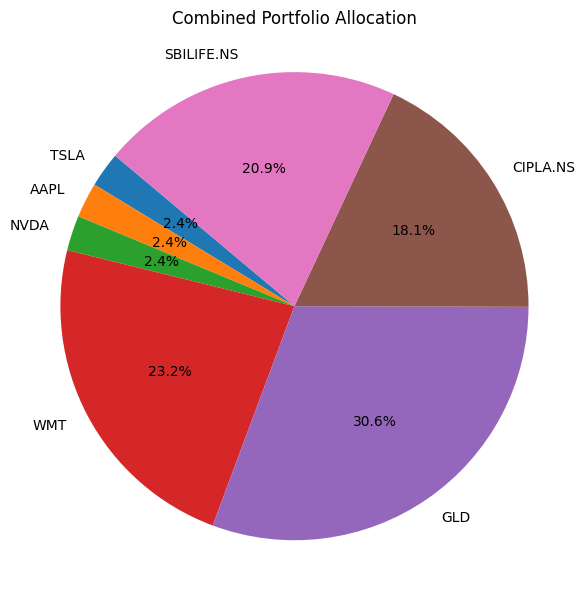

In [77]:
# Pie Chart - Allocation
plt.figure(figsize=(6, 6))
final_weights = np.array(combined_weights)
labels = [t for t, w in zip(combined_tickers, final_weights) if w > 0.02]
sizes = [w for w in final_weights if w > 0.02]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Combined Portfolio Allocation")
plt.axis('equal')
plt.tight_layout()
plt.show()

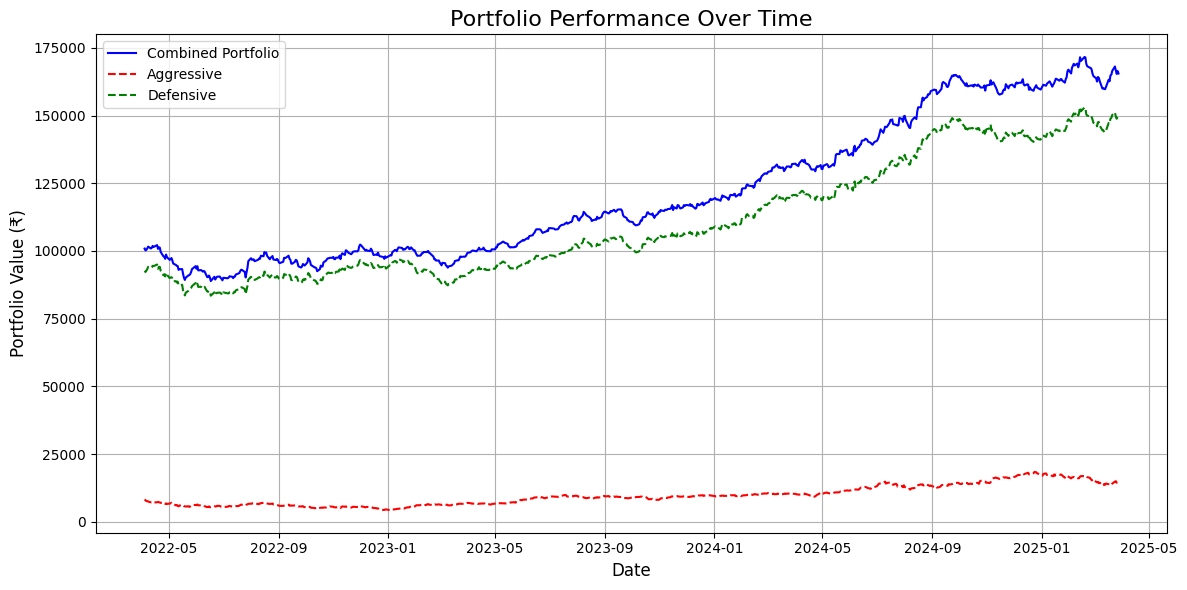

In [78]:
# Portfolio Value Over Time
plt.figure(figsize=(12, 6))
plt.plot(combined_value.index, combined_value.values, label='Combined Portfolio', color='blue')
plt.plot(agg_value.index, agg_value.values, label='Aggressive', linestyle='--', color='red')
plt.plot(def_value.index, def_value.values, label='Defensive', linestyle='--', color='green')
plt.title("Portfolio Performance Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value (₹)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

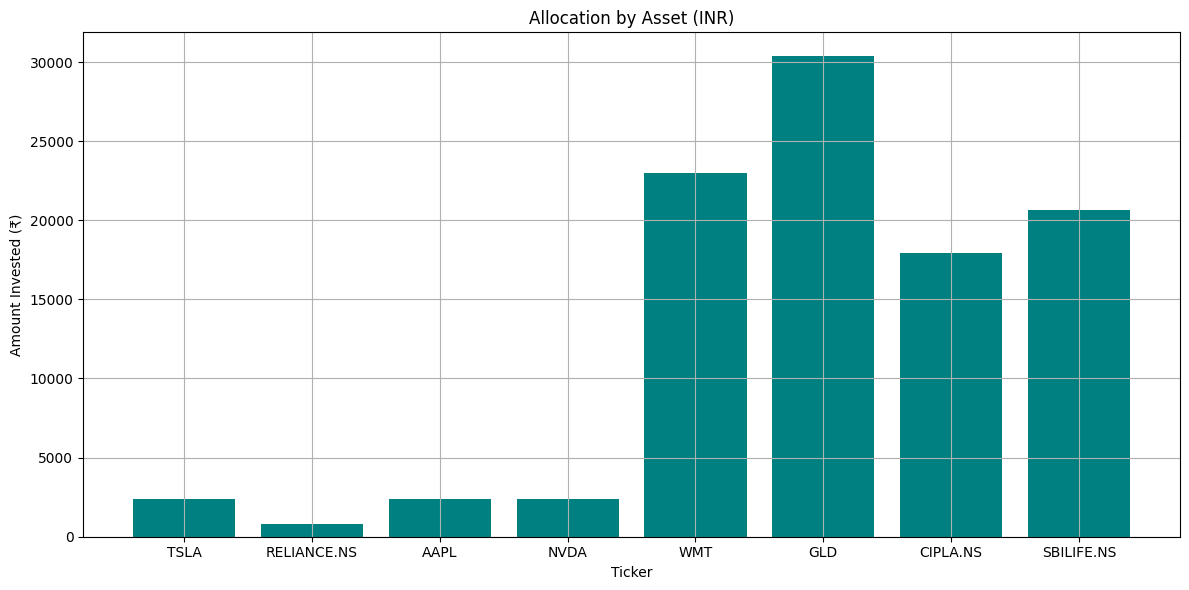

In [79]:
# Bar Chart - INR Allocation
alloc_inr = np.array(combined_weights) * 100000
tickers_inr = [t for t, w in zip(combined_tickers, alloc_inr) if w > 100]
allocs = [w for w in alloc_inr if w > 100]

plt.figure(figsize=(12, 6))
plt.bar(tickers_inr, allocs, color='teal')
plt.title("Allocation by Asset (INR)")
plt.xlabel("Ticker")
plt.ylabel("Amount Invested (₹)")
plt.grid(True)
plt.tight_layout()
plt.show()